In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pylcp
from pylcp.common import progressBar

In [2]:
def H(t, Delta0, Omega0, omegam):
    Delta = Delta0*np.cos(omegam*t)
    Omega = Omega0*np.sin(omegam*t)

    return 1/2*np.array([[Delta, Omega], [Omega, -Delta]])

In [45]:
def return_lasers(Delta0, Omega0, omegam):
    laserBeams = pylcp.laserBeams([
        {'kvec':np.array([1., 0., 0.]),
         'pol':np.array([0., 0., 1.]),
         'pol_coord':'cartesian',
         'delta': lambda t: Delta0*np.cos(omegam*t),
         'phase': 0,#lambda t: Delta0/omegam*np.sin(omegam*t),
         's': lambda R, t: 2*(Omega0*np.sin(omegam*t))**2
        }])

    return laserBeams

magField = lambda R: np.zeros(R.shape)

# Now define the extremely simple Hamiltonian:
Hg = np.array([[0.]])
mugq = np.array([[[0.]], [[0.]], [[0.]]])
He = np.array([[0.]])
mueq = np.array([[[0.]], [[0.]], [[0.]]])
dijq = np.array([[[0.]], [[1.]], [[0.]]])

gamma = 1.

hamiltonian = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq, gamma=gamma)
hamiltonian.print_structure()

[[((<g|H_0|g> 1x1), (<g|mu_q|g> 1x1)) (<g|d_q|e> 1x1)]
 [(<e|d_q|g> 1x1) ((<e|H_0|e> 1x1), (<e|mu_q|e> 1x1))]]


In [64]:
Delta0 = 10.
Omega0 = 10.
omegam = 1

t = np.linspace(0., np.pi/omegam, 201)
sol_SE = solve_ivp(lambda t, y: -1j*H(t, Delta0, Omega0, omegam)@y, [0, np.pi/omegam],
                   np.array([1., 0.], dtype='complex128'), t_eval=t)

laserBeams = return_lasers(Delta0, Omega0, omegam)
obe = pylcp.obe(laserBeams, magField, hamiltonian)
obe.ev_mat['decay'] = np.zeros(obe.ev_mat['decay'].shape) # Turn off damping to compare to Schrodinger Equation.
obe.set_initial_rho_from_populations(np.array([1., 0.]))
sol_OBE = obe.evolve_density([0, np.pi/omegam], t_eval=t)

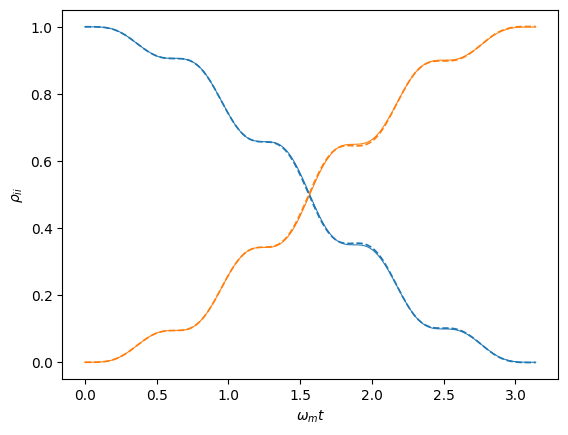

In [65]:
fig, ax = plt.subplots(1, 1)
ax.plot(sol_SE.t, np.abs(sol_SE.y[0])**2, linewidth=0.75)
ax.plot(sol_SE.t, np.abs(sol_SE.y[1])**2, linewidth=0.75)
ax.plot(sol_OBE.t, np.real(sol_OBE.rho[0, 0]), '--', color='C0', linewidth=1.25)
ax.plot(sol_OBE.t, np.real(sol_OBE.rho[1, 1]), '--', color='C1', linewidth=1.25)
ax.set_xlabel('$\omega_m t$')
ax.set_ylabel('$\\rho_{ii}$');

In [68]:
(np.abs(sol_SE.y[1])**2)[-1]

np.float64(0.9991891610434323)

In [6]:
Delta0s = np.arange(0.25, 25.1, 0.25)
Omega0s = np.arange(0.25, 25.1, 0.25)
t = np.linspace(0., np.pi, 201)

DELTA0S, OMEGA0S = np.meshgrid(Delta0s, Omega0s)

it = np.nditer([DELTA0S, OMEGA0S, None])

progress = progressBar()

for (Delta0, Omega0, rhogg) in it:
    del laserBeams

    # Set up new laser beams:
    laserBeams = return_lasers(Delta0, Omega0, omegam)

    # Set up OBE:
    obe = pylcp.obe(laserBeams, magField, hamiltonian)
    obe.ev_mat['decay'] = np.zeros(obe.ev_mat['decay'].shape) # Turn off damping to compare to Schrodinger Equation.
    obe.set_initial_rho_from_populations(np.array([1., 0.]))

    # Solve:
    sol_OBE = obe.evolve_density([0, np.pi], t_eval=t)

    # Save result:
    rhogg[...] = np.real(sol_OBE.rho[0, 0, -1])

    # Update progress bar:
    progress.update((it.iterindex+1)/it.itersize)

RHOGG = it.operands[2]

Completed in 1:53.                                                  


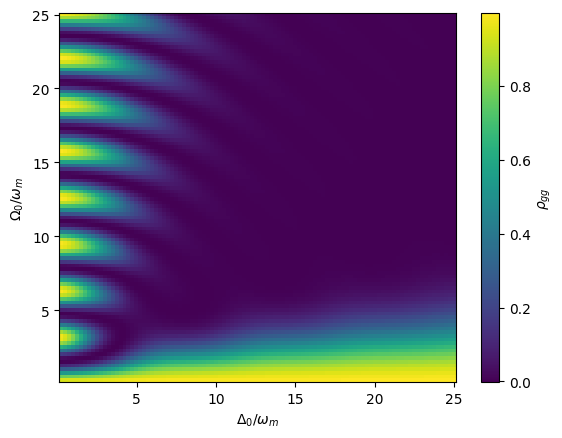

In [7]:
dDelta0 = np.mean(np.diff(Delta0s))
dOmega0 = np.mean(np.diff(Omega0s))
fig, ax = plt.subplots(1, 1)
im = ax.imshow(RHOGG, origin='lower',
               extent=(np.amin(Delta0s)-dDelta0/2, np.amax(Delta0s)+dDelta0/2,
                       np.amin(Omega0s)-dOmega0/2, np.amax(Omega0s)+dOmega0/2),
               aspect='auto')
ax_cbar = plt.colorbar(im)
ax_cbar.set_label('$\\rho_{gg}$')
ax.set_xlabel('$\Delta_0/\omega_m$')
ax.set_ylabel('$\Omega_0/\omega_m$');